*This notebook was created by Mykola Veremchuk (mykola.veremchuk@xfel.eu), Svitozar Serkez. Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). June 2019.*

## PFS tutorial N4. Converting synchrotron radiation results from `Screen` object to `RadiationField`

`ocelot.optics.wave.RadiationField` objects can be used for analysis as well as propagation of Synchrotron radiation module output

### Contents
1. [2D synchrotron radiation field](#2d)
    * [Generating 2D Screen](#gen_screen_2d)
    * [Converting 2D Screen to 2D RadiationField](#gen_dfl_2d)
    * [Plotting RadiationField](#plot_dfl_2d) 
2. [3D synchrotron radiation field](#3d)
    * [Generating 3D Screen](#gen_screen_3d)
    * [Converting 3D Screen to 3D RadiationField](#gen_dfl_3d)
    * [Plotting RadiationField](#plot_dfl_3d)

### Necessary imports

In [1]:
import numpy as np
import logging
from ocelot import *
from ocelot.rad import *
from ocelot.optics.wave import dfl_waistscan, screen2dfl, RadiationField, WignerDistribution, dfl2wig
from ocelot.gui.dfl_plot import plot_dfl, plot_dfl_waistscan, plot_wigner
from ocelot import ocelog

ocelog.setLevel(logging.ERROR) #suppress logger output

initializing ocelot...


In [2]:
# Activate interactive matplolib in notebook
import matplotlib
%matplotlib inline
# Setup figure white background 
matplotlib.rcParams["figure.facecolor"] = (1,1,1,1)
# Setup figure size
matplotlib.rcParams['figure.figsize'] = [10, 10]

<a id='2d'></a>
## 2D synchrotron radiation field
<a id='gen_screen_2d'></a>
### Generating 2D Screen
See [9_synchrotron_radiation.ipynb](9_synchrotron_radiation.ipynb) tutorial first,
reproducing the 2d visualization

In [3]:
# generating 2D synchrotron radiation (it will take about 1-3 minutes)
und = Undulator(Kx=0.43, nperiods=500, lperiod=0.007, eid="und")
lat = MagneticLattice(und)

beam = Beam()
beam.E = 2.5  # beam energy in [GeV]
beam.I = 0.1  # beam current in [A]


screen_2d = Screen()
screen_2d.z = 100.0        # distance from the begining of lattice to the screen 
screen_2d.size_x = 0.002   # half of screen size in [m] in horizontal plane
screen_2d.size_y = 0.002   # half of screen size in [m] in vertical plane
screen_2d.nx = 51          # number of points in horizontal plane 
screen_2d.ny = 51          # number of points in vertical plane 


screen_2d.start_energy = 7761.2 # [eV], starting photon energy
screen_2d.end_energy = 7761.2     # [eV], ending photon energy
screen_2d.num_energy = 1        # number of energy points[eV]

screen_2d = calculate_radiation(lat, screen_2d, beam)

<a id='gen_dfl_2d'></a>
### Converting 2D Screen to 2D RadiationField

to convert SR from Screen to RadiationField there is a function:

```dfl = screen2dfl(screen, polarization='x')```
* ```screen```: Screen object, electric field of which will be used to generate RadiationField
* ```polarization```:  polarization for conversion to RadiationField ($E_x$ or $E_y$)

see [11_radiation_field.ipynb](11_radiation_field.ipynb)

In [4]:
dfl_2d = screen2dfl(screen_2d, polarization='x') 

<a id='plot_dfl_2d'></a>
### Plotting RadiationField

2D (monochromatic) RadiationFied generated from Screen 

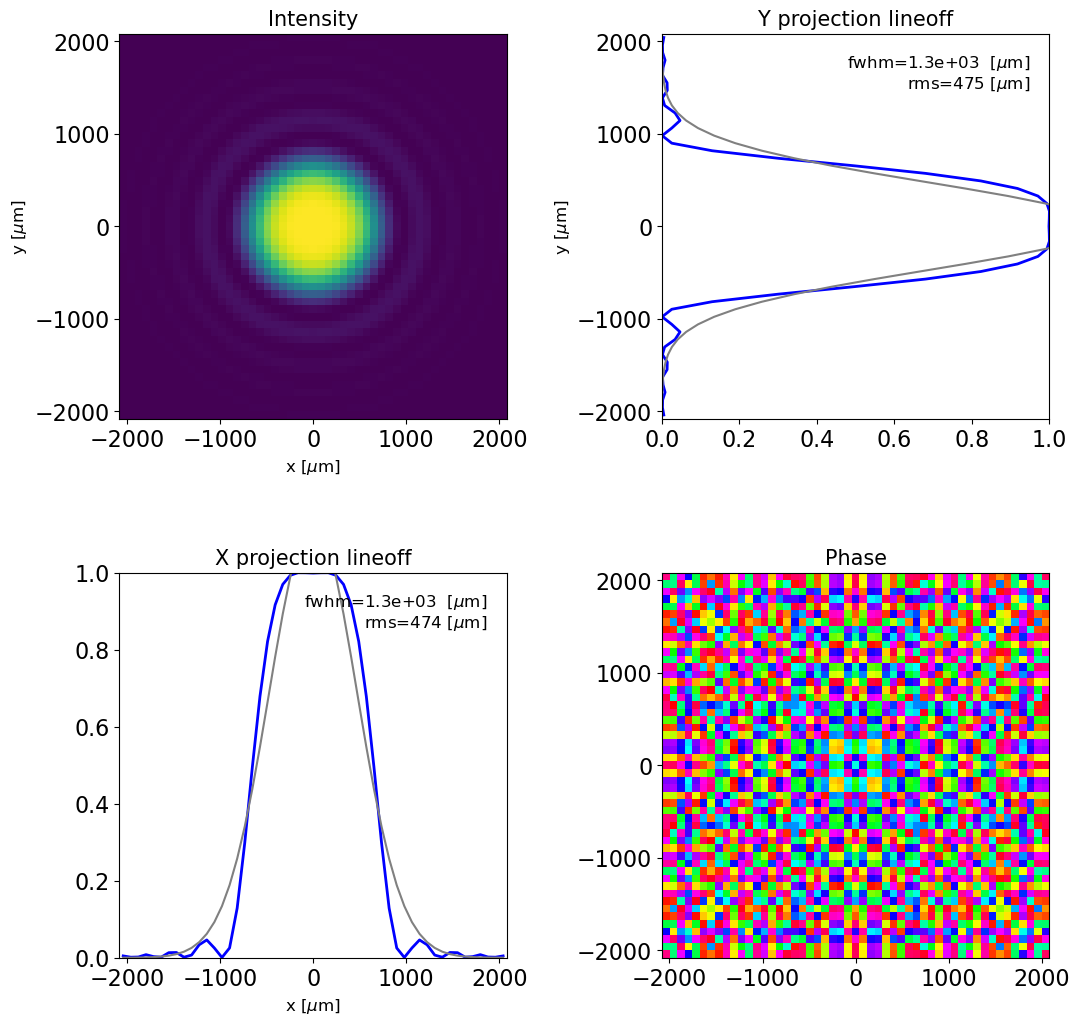

In [5]:
plot_dfl(dfl_2d,
         fig_name='dfl_2d generated from screen_2d', 
         column_3d=1)

The phase is oscillating very rapidly. Let's study the radiation back-propagated to the middle of the undulator

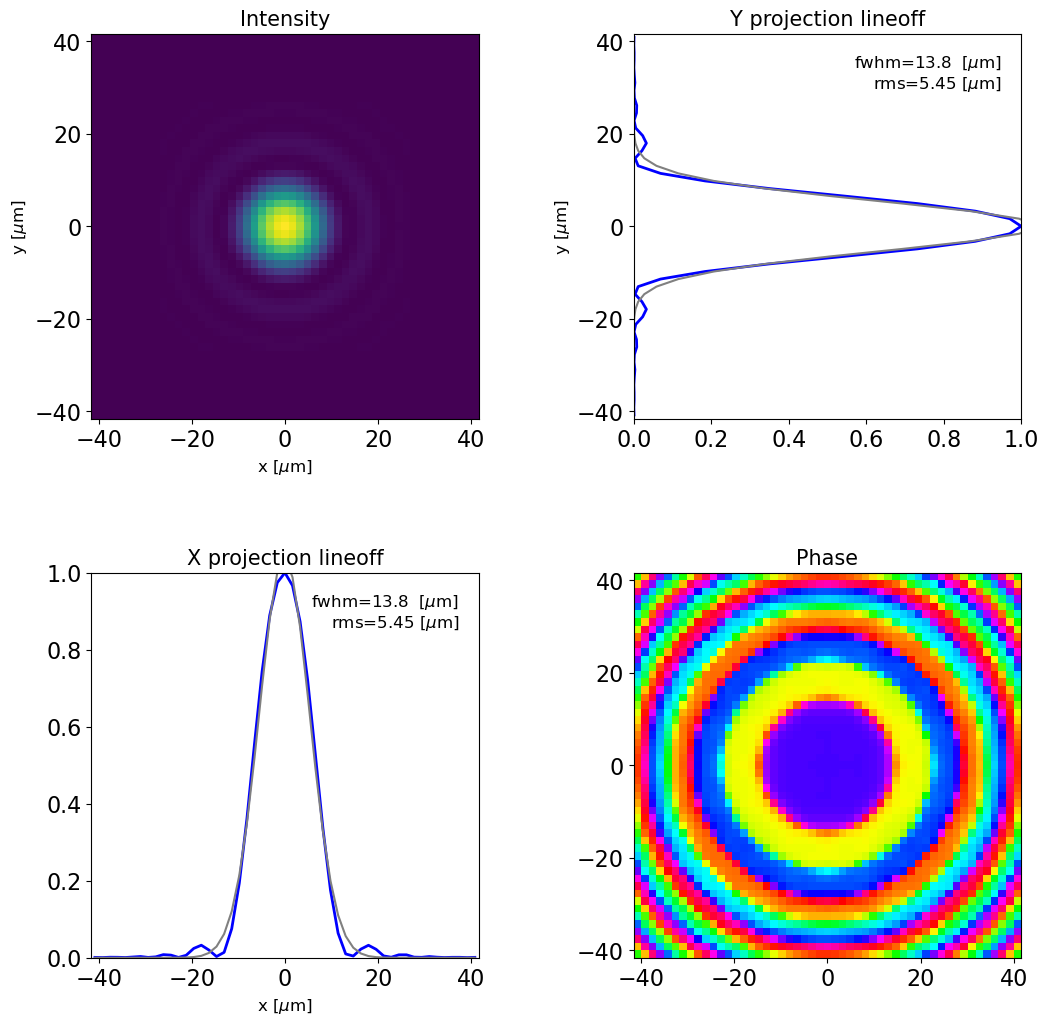

In [6]:
dfl_2d.prop_m(-100-3.5/2, m=0.02)
plot_dfl(dfl_2d,
         fig_name='dfl_2d generated from screen_2d')

and now we can study transverse Wigner distribution of undulator radiation:
(see https://link.aps.org/doi/10.1103/PhysRevSTAB.15.050703 for reference)
as the radiation propagates, is evolves, just like the transverse phase-space of an electron beam

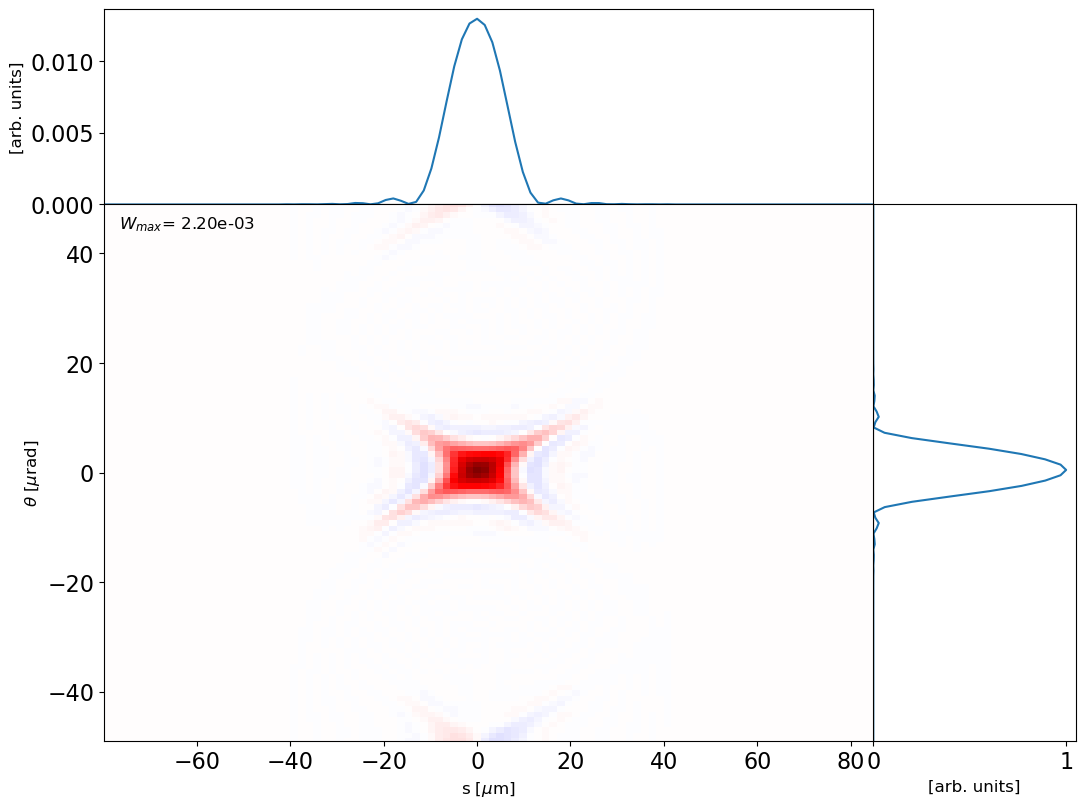

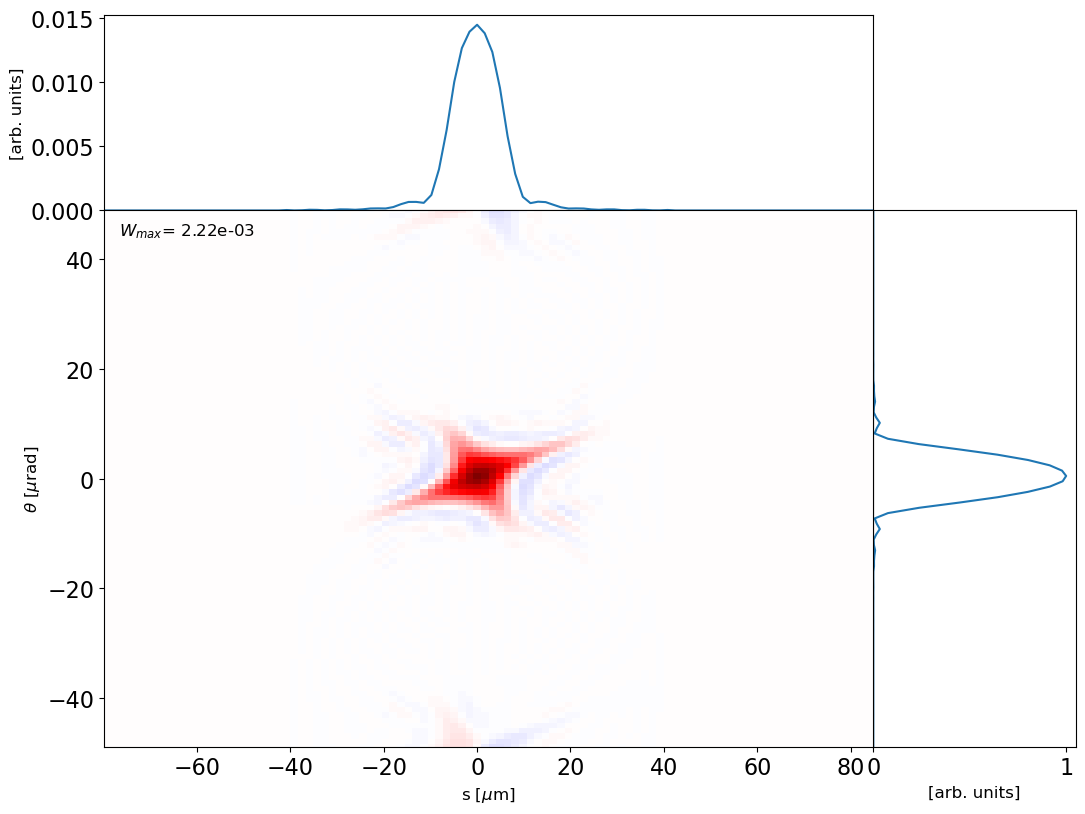

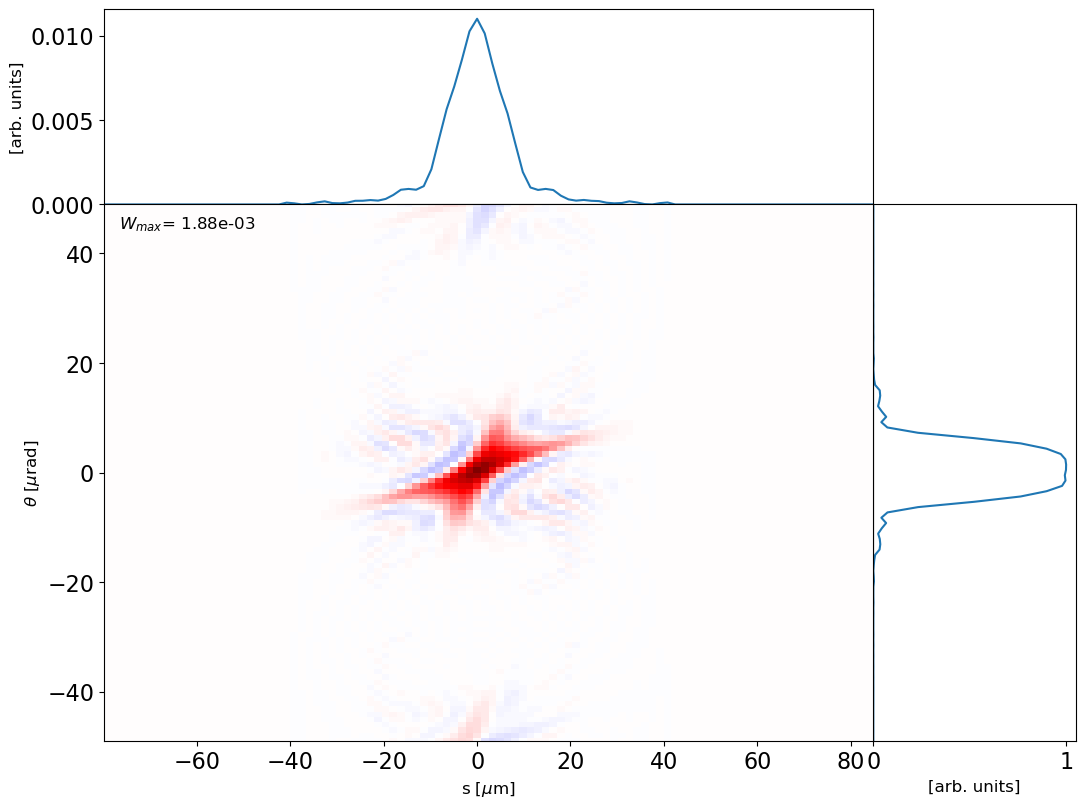

In [7]:
wig = dfl2wig(dfl_2d, domain='x', pad=2)
plot_wigner(wig)

plot_wigner(dfl2wig(dfl_2d.prop_m(1, m=1, return_result=True), domain='x', pad=2)) #1m downstream the waist
plot_wigner(dfl2wig(dfl_2d.prop_m(2, m=1, return_result=True), domain='x', pad=2)) #2m downstream the waist

<a id='gen_screen_3d'></a>
### Generating and converting 3D Screen
One can calculate series of 2D radiation field distributions at different photon energies.

In [8]:
# generating 3D synchrotron radiation (it will take up to 5 minutes as 75*75*20=112k datapoints are calculated)
screen_3d = Screen()
screen_3d.z = 100.0  # distance from the begining of lattice to the screen
screen_3d.size_x = 0.002  # half of screen size in [m] in horizontal plane
screen_3d.size_y = 0.002  # half of screen size in [m] in vertical plane

screen_3d.ny = 50
screen_3d.nx = 50
screen_3d.start_energy = 7720  # [eV], starting photon energy
screen_3d.end_energy = 7790  # [eV], ending photon energy
screen_3d.num_energy = 25  # number of energy points[eV]

screen_3d = calculate_radiation(lat, screen_3d, beam)
dfl_3d = screen2dfl(screen_3d, polarization='x')

SR 3D calculation


In this way we obtain a 3D RadiationFied distribution in space-frequency domain

Note the spatial dependence on the photon energy. The slice values of x=0 and y=0 are provided as well as on-axis spectrum

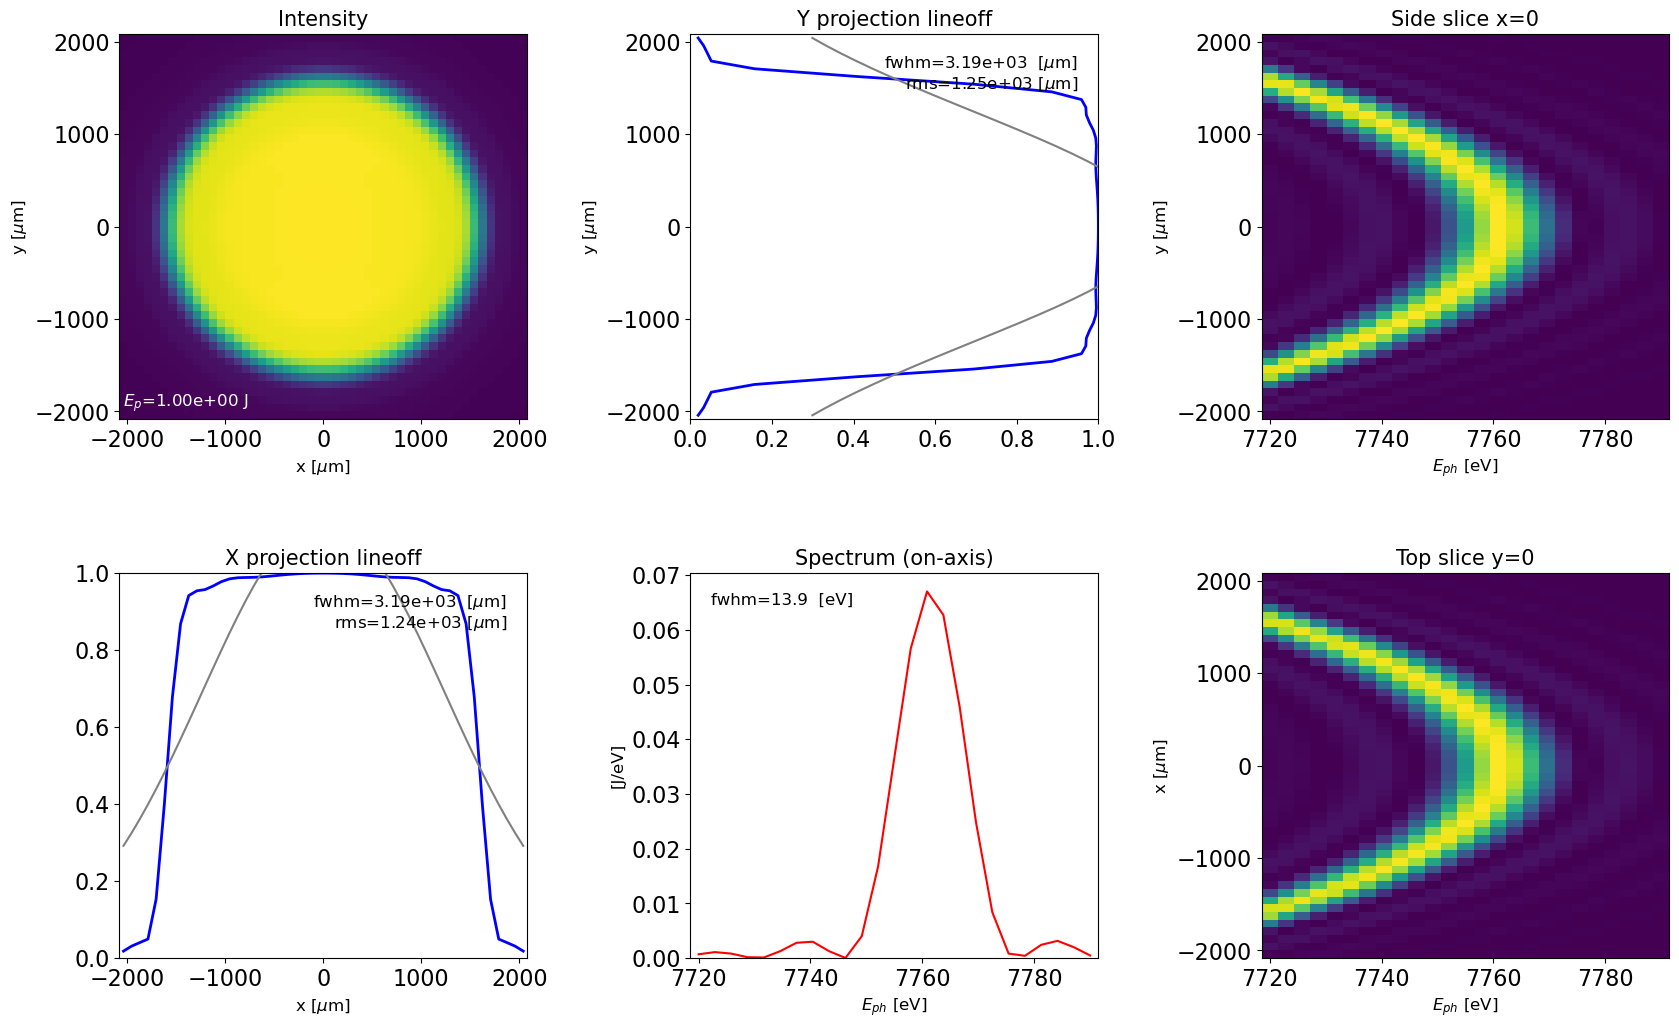

In [9]:
plot_dfl(dfl_3d, 
         domains='sf',
         fig_name='dfl_3d in space-frequency domain',
         slice_xy=True) # bool type variable, if True, slices will be plotted; if False, projections will be plotted

Transverse projections and integrated spectrum

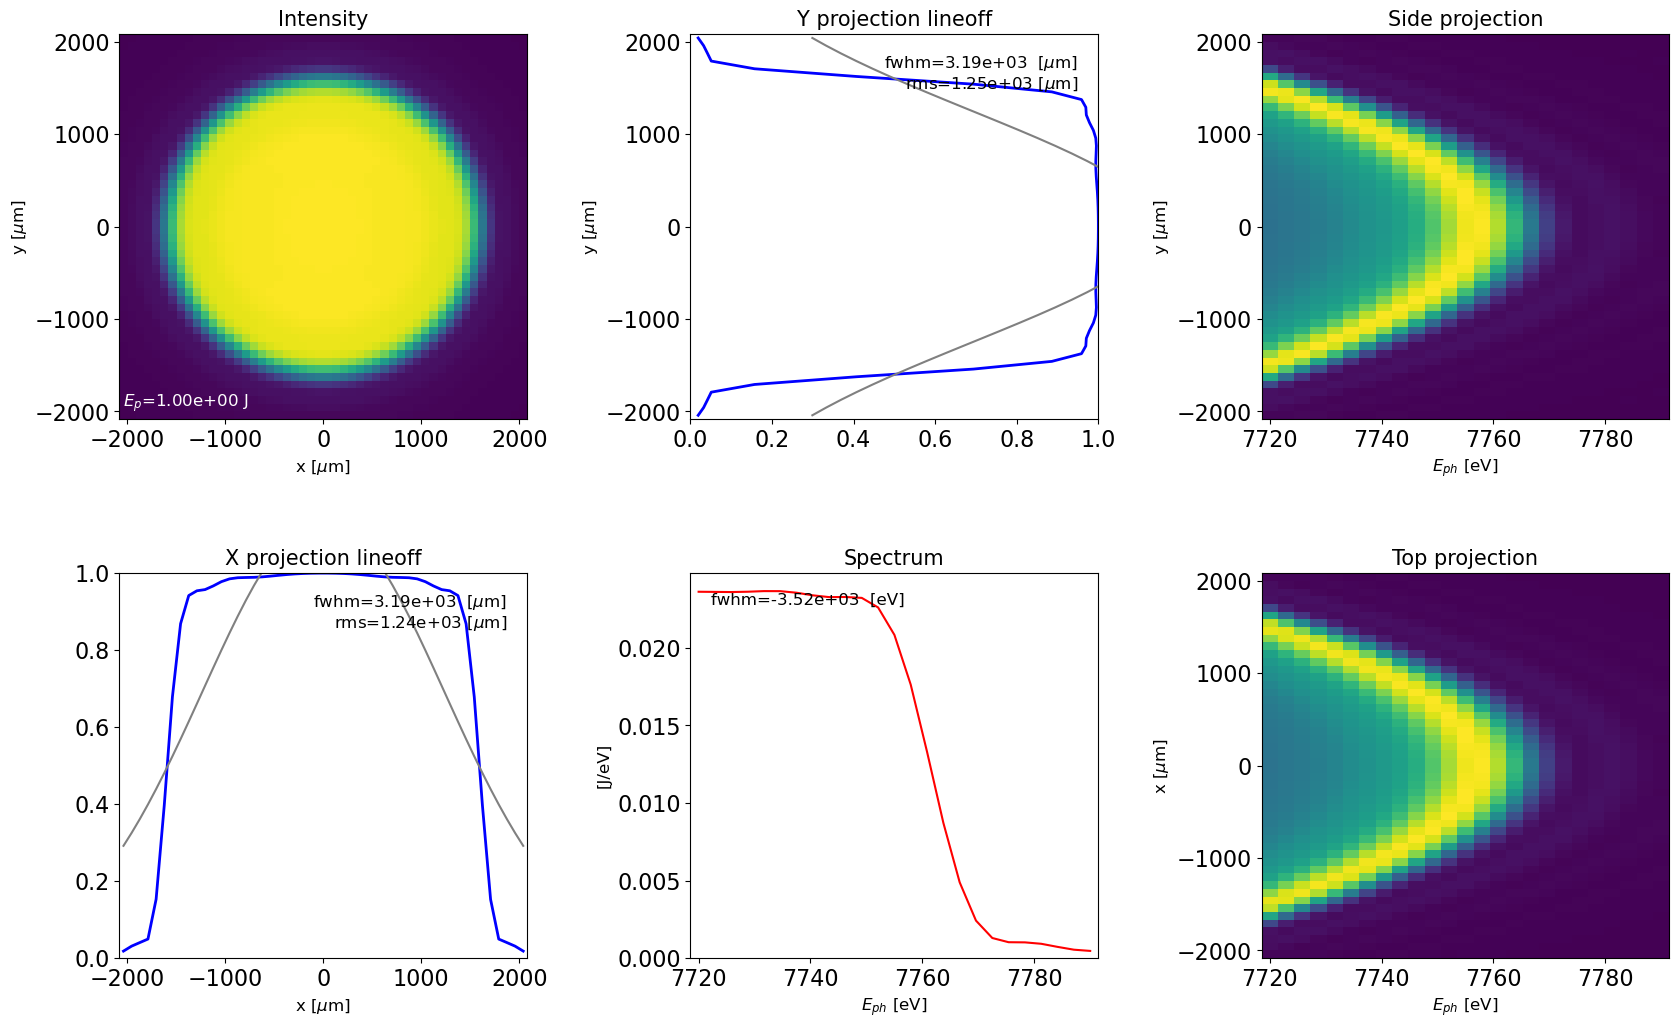

In [10]:
plot_dfl(dfl_3d, 
         domains='sf',
         fig_name='dfl_3d in space-frequency domain',
         slice_xy=False)

Plotting in space-time domain yields pulse duration that is approximately the radiation wavelength (fundamental harmonic) times number of undulator periods
The expected pulse duration from a single electron at this harmonic should be about 0.08um.

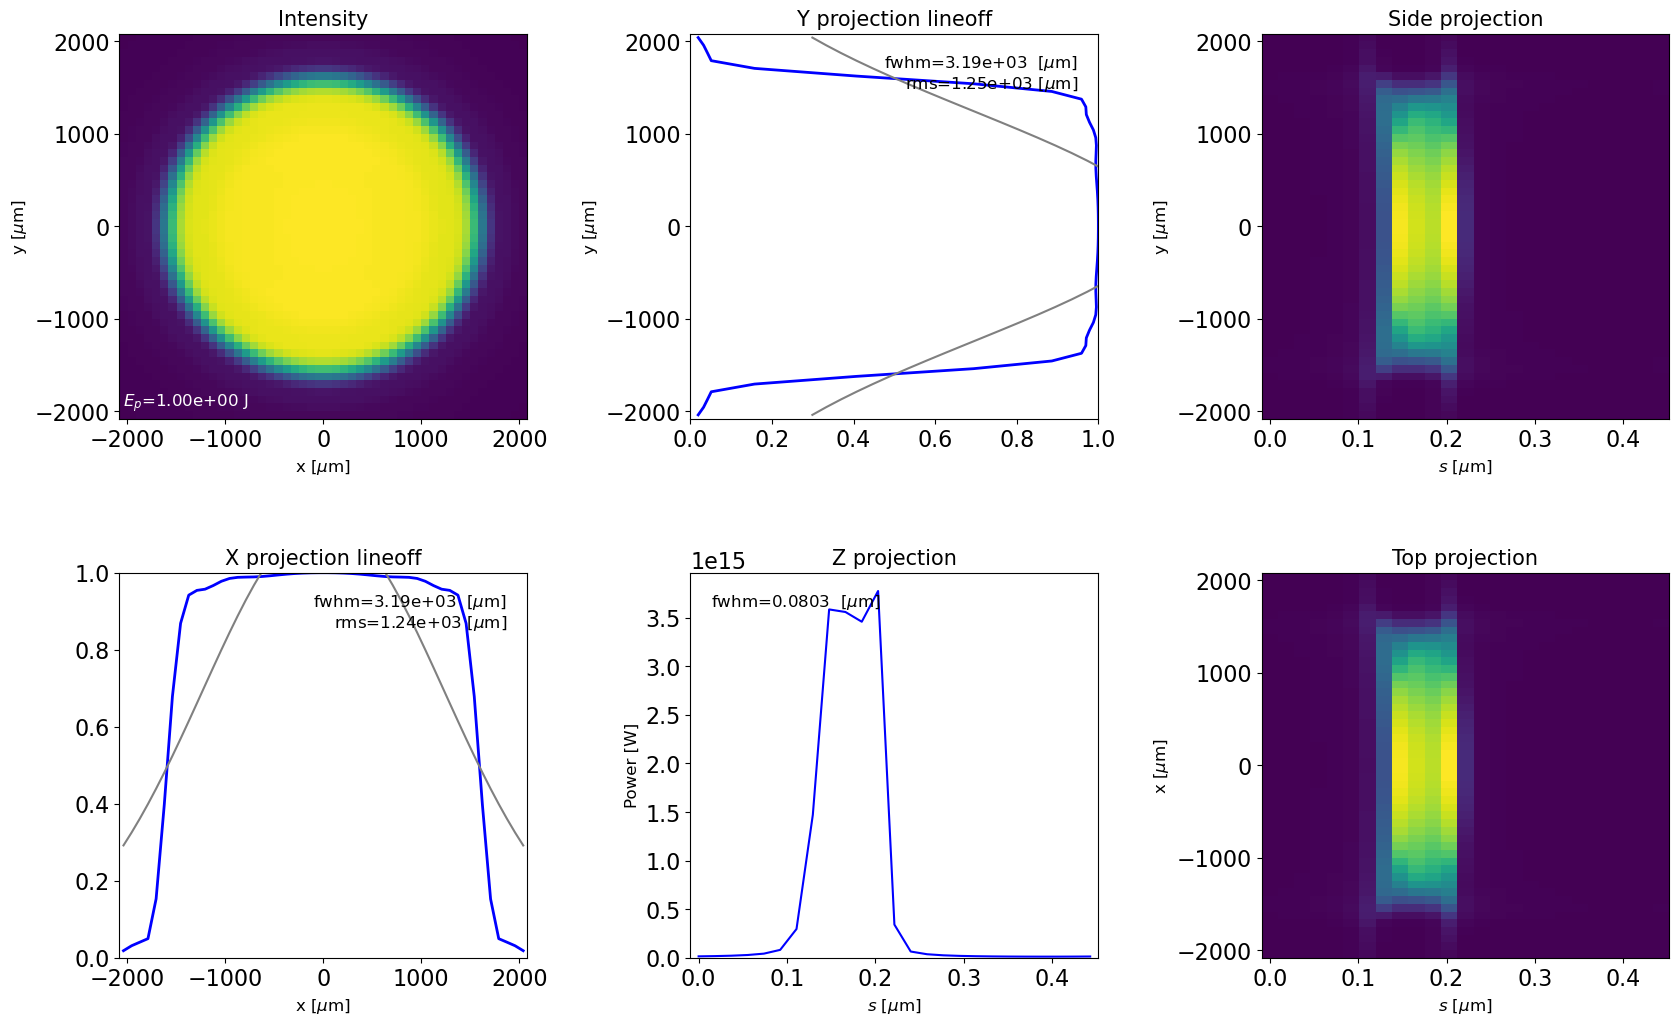

In [11]:
plot_dfl(dfl_3d,
         domains='st',
         fig_name='dfl_3d in space-time domain',
         slice_xy=False)

Radiation distribution in the middle of the undulator

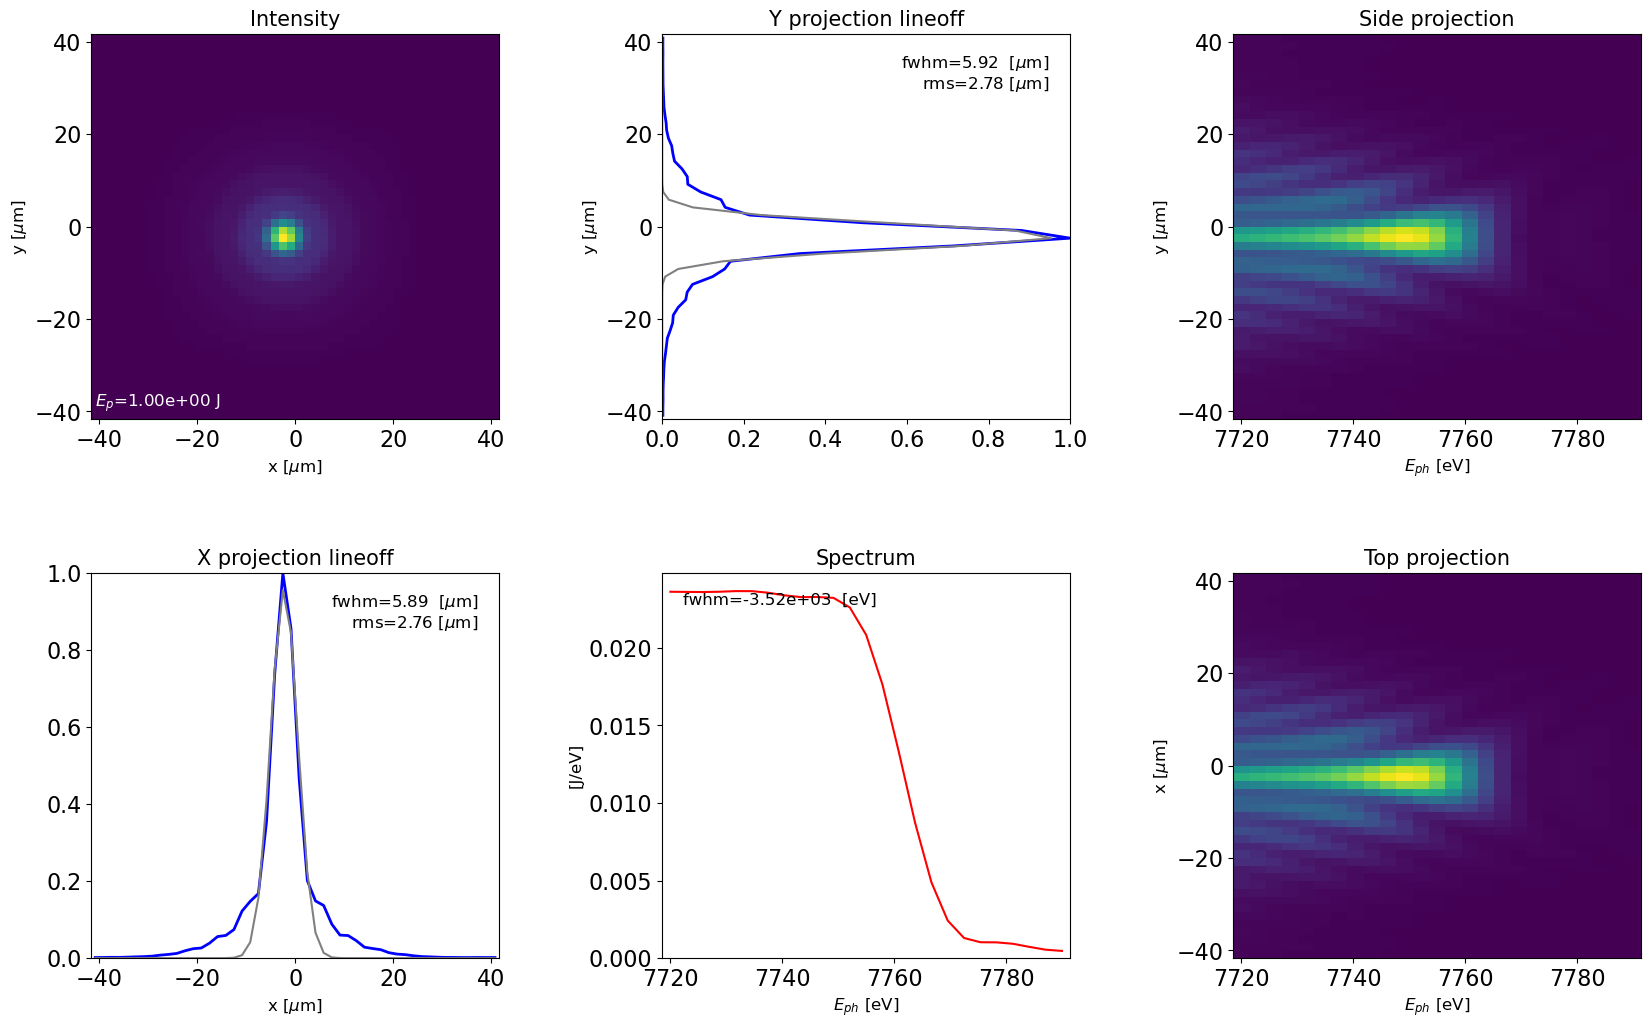

In [12]:
plot_dfl(dfl_3d.prop_m(-100-3.5/2, m=0.02, fine=1, return_result=1),
         domains='fs',
         fig_name='dfl_3d at waist position in frequency-space domains',
         slice_xy=False)

Because of the rapidly-oscilalting phase, plotting in the far zone in not possible yet, to be solved in the future by subtracting spherical phase component

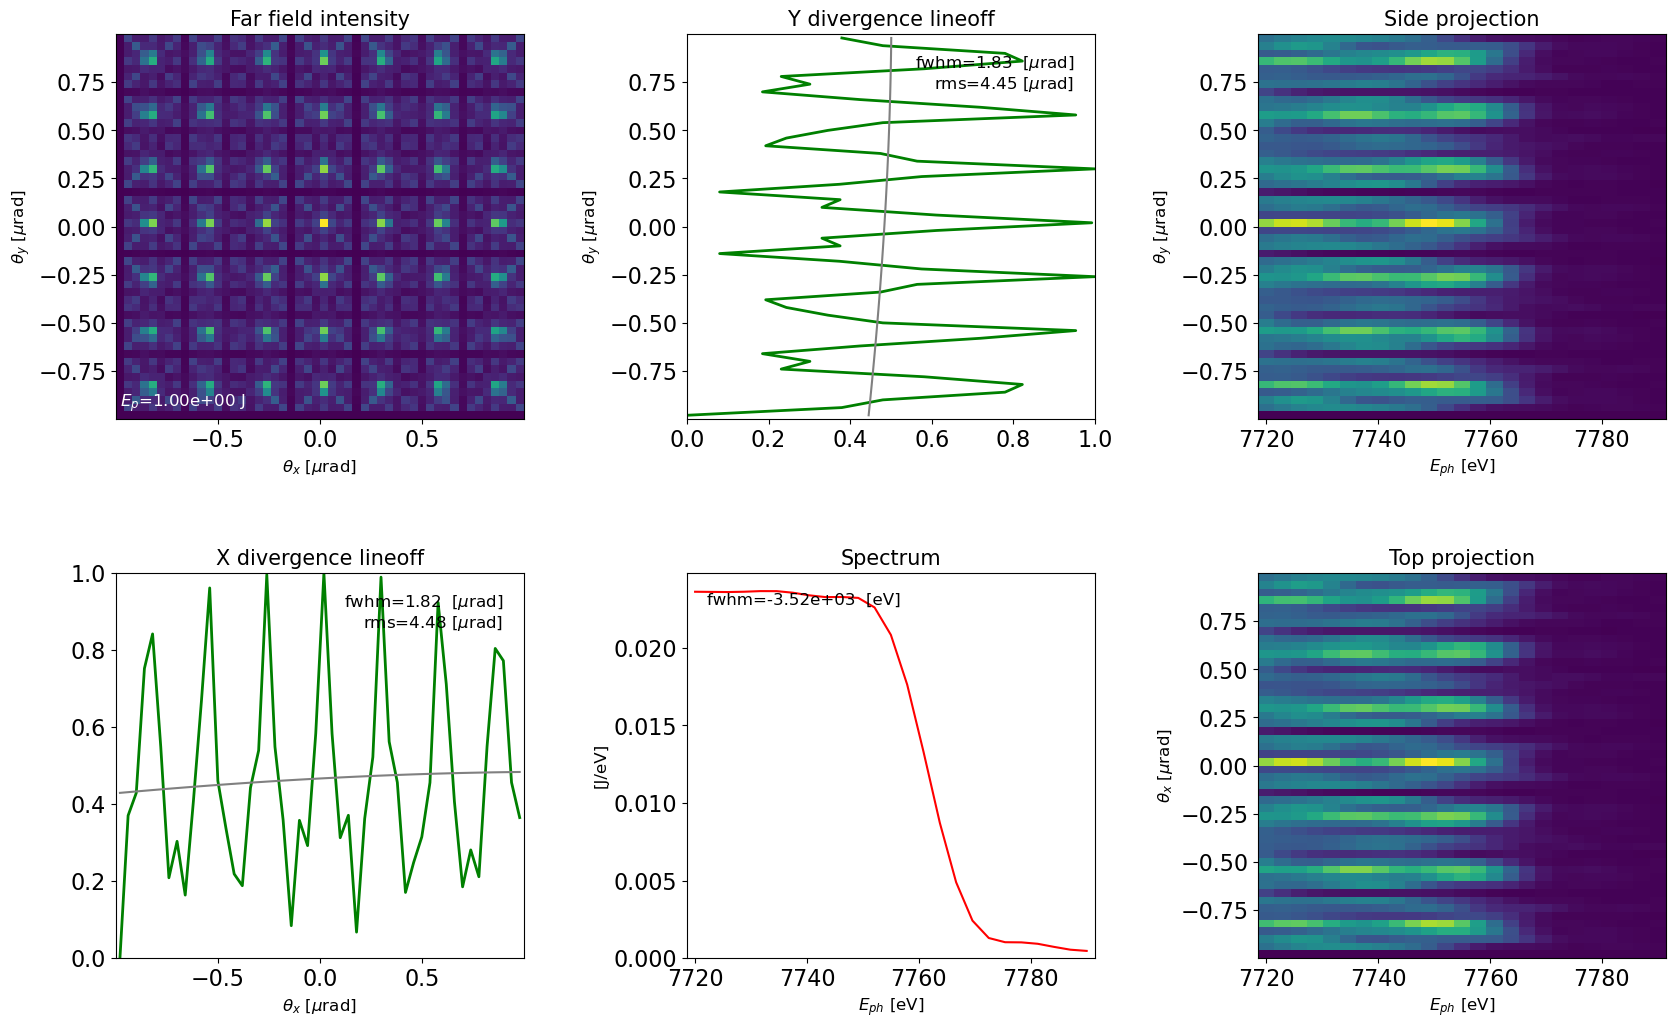

In [13]:
plot_dfl(dfl_3d,
         domains='fk',
         fig_name='dfl_3d at waist position in inverse space-frequency domains',
         slice_xy=False)